# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import statsmodels.stats.weightstats
df = pd.read_csv('data/human_body_temperature.csv')

In [2]:
print(df.shape)
print(df.describe())
df.head()

(130, 3)
       temperature  heart_rate
count   130.000000  130.000000
mean     98.249231   73.761538
std       0.733183    7.062077
min      96.300000   57.000000
25%      97.800000   69.000000
50%      98.300000   74.000000
75%      98.700000   79.000000
max     100.800000   89.000000


,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


#### 1. Is the distribution of body temperatures normal?

/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


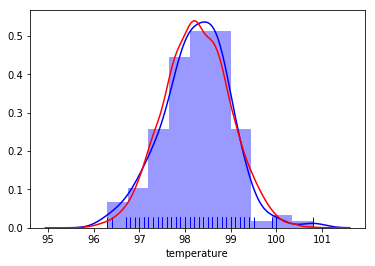

In [3]:
norm = np.random.normal(size=10000, loc=98.249231, scale=0.733183)

# would want to do this after means of bootstrapping empirical data. 
# Don't use random sample for the normal distribution because we're using theoretical distribution. 

_ = sns.distplot(df.temperature, bins=10, rug=True, color='blue')
_ = sns.distplot(norm, hist=False, rug=False, color='red') 

### Shapiro-Wilk Test 
* Ho: The distribution of the data is normal. 
* Ha: The distribution of the data is not normal.

In [4]:
# https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

# Shapiro-Wilk Test
from scipy.stats import shapiro

np.random.seed(1)

# normality test
stat, p = shapiro(df.temperature)
print('Statistics=%.3f, p=%.3f' % (stat, p))
#? Hunh? pipeline in python for printing??

# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.987, p=0.233
Sample looks Gaussian (fail to reject H0)


#### 2. Is the sample size large? Are the observations independent?

*  The sample size is 130 (over 30). 
*  Observations can be treated as independent because 130 is less than 10% of the world population, if we assume that Wunderlich sampled without replacement. 

#### 3. Is the true population mean really 98.6 degrees F?
No. Bootstrapping and other tests reveal that the true poplation mean is not 98.6 degrees F.

In [28]:
#Bootstrap hypothesis test:
# Ho : The true population mean is 98.6 degrees F.
# Ha : The true population mean is not 98.6 degrees F.

# FUNCTIONS:

def bs_rep_1d(data,func):
    """generate bootstrap replicate of 1D data"""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bs_rep_1d(data, func)

    return bs_replicates

# APPLICATION 1, shifting data mean and comparing bootstrap distance with empirical distance

alpha = .05
temps = df.temperature
assumed = 98.6 

# Difference between Ho mean and sample mean
def diff_from_assumed(data, assumed=98.6):
    return np.mean(data) - assumed
diff_obs = diff_from_assumed(temps)

# Shift data set:
temps_shift = temps - np.mean(temps) + assumed

# 10,000 sets of bootstrap data
bs_reps = draw_bs_reps(temps_shift, diff_from_assumed, 10000)

# percentage of bootstrap data with difference less that observed difference between sample mean and assumed mean
p_value = np.sum(bs_reps <= diff_obs) / len(bs_reps)

print("Reject Ho because %.3f, is less than %.3f." % (p_value, alpha)) if p_value < alpha \
else print("Fail to reject Ho because of P value=%.3f is greater than alpha=%.3f." % (p_value, alpha))




# APPLICATION 2, bootstrapping mean and comparing rounded mean with Ho mean

alpha = .05
temps = df.temperature
assumed = 98.6 

# Difference between Ho mean and sample mean

# 10,000 sets of bootstrap data
bs_reps = draw_bs_reps(temps, np.mean, 10000)
bs_repsr = [round(i,1) for i in bs_reps] 

# percentage of bootstrap data with difference less that observed difference between sample mean and assumed mean
p_value = np.sum((bs_repsr) != assumed) / len(bs_reps)

print("Reject Ho because %.3f, is less than %.3f." % (p_value, alpha)) if p_value < alpha \
else print("Fail to reject Ho because of P value=%.3f is greater than alpha=%.3f." % (p_value, alpha))

Reject Ho because 0.000, is less than 0.050.
Reject Ho because 0.000, is less than 0.050.


One-sample or two-sample test? Why?
*  We use a one-sample test because we are comparing one set of data (Wunderlich's) to another statistic (mean=98.6).
*  We would use a two-sample test if we used two data sets. 

Should we use t or z statistic? Why? 
*  The population variance is unknown, but the sample size above 30 and the data is normally is distributed. A T distribution may be slightly better than a Z distribution. 
*  Z distributions can be used when the population variance isn't known by estimating with the sample variance. The sample size must be over 30, and the data must be normally distributed.
    
Use the other test. How are the result different and why? 
*  The results are different because the curve for a t distribution changes depending on the sample size, as reflected in the degrees of freedom used in the calculation. This accounts for the unknown population variance. 

In [6]:
smean = np.mean(temps)
pmean = 98.6
sstd = np.std(temps)
ssize = len(temps)
degf = ssize - 1

# t statistic: 
results = st.ttest_1samp(temps, 98.6)
alpha = 0.05

print("T Statistic: %.10f is less than %f, so we reject Ho." % (results[1], alpha)) if results[1] < alpha \
else print("T Statistic: %.10f is more than %f, so we fail to reject Ho." % (results[1], alpha))

# t statistic another way: (sample mean - population mean)/(standard deviation of SAMPLE / square root of sample size)
SE = (np.std(temps)/np.sqrt(ssize))
t = (smean - 98.6) / SE
pval = st.t.sf(np.abs(t), degf)*2

print("T Statistic: %.10f is less than %f, so we reject Ho." % (pval, alpha)) if results[1] < alpha \
else print("T Statistic: %.10f is more than %f, so we fail to reject Ho." % (pval, alpha))

# z statistic: 
results = statsmodels.stats.weightstats.ztest(x1=temps, value=98.6)
alpha = 0.05

print("Z Statistic: %.10f is less than %f, so we reject Ho." % (results[1], alpha)) if results[1] < alpha \
else print("Z Statistic: %.10f is more than %f, so we fail to reject Ho." % (results[1], alpha))

# z statistic another way: use sample standard deviation to estimate population standard deviation.
# This brings us to the same formula for T statistic, but without using DF in finding P from Z distribution.
# (sample mean - population mean)/(standard deviation of POPULATION / square root of sample size)
SE = (np.std(temps)/np.sqrt(ssize))
z = (smean - 98.6) / SE
pval = st.norm.sf(abs(z))*2 

print("Z Statistic: %.10f is less than %f, so we reject Ho." % (pval, alpha)) if results[1] < alpha \
else print("Z Statistic: %.10f is more than %f, so we fail to reject Ho." % (pval, alpha))

T Statistic: 0.0000002411 is less than 0.050000, so we reject Ho.
T Statistic: 0.0000002189 is less than 0.050000, so we reject Ho.
Z Statistic: 0.0000000490 is less than 0.050000, so we reject Ho.
Z Statistic: 0.0000000435 is less than 0.050000, so we reject Ho.


##### 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.
* Which one is the correct one to use?
  *  We use the t test because the population variance is unknown and the sample is under 30.
* What do you notice? What does this tell you about the difference in application of the  𝑡  and  𝑧  statistic?
  * The larger the sample size, the less it matters whether or not we use a t or z statistic because the standard deviation will approach the same value.

In [7]:
np.random.seed(15)
tsmall = np.random.choice(temps, 10)

# t statistic:
results = st.ttest_1samp(tsmall, 98.6)
alpha = 0.05

print("T Statistic: %.10f is less than %f, so we reject Ho." % (results[1], alpha)) if results[1] < alpha \
else print("T Statistic: %.10f is more than %f, so we fail to reject Ho." % (results[1], alpha))

# z statistic: 
results = statsmodels.stats.weightstats.ztest(x1=tsmall, value=98.6)
alpha = 0.05

print("Z Statistic: %.10f is less than %f, so we reject Ho." % (results[1], alpha)) if results[1] < alpha \
else print("Z Statistic: %.10f is more than %f, so we fail to reject Ho." % (results[1], alpha))

T Statistic: 0.0248671107 is less than 0.050000, so we reject Ho.
Z Statistic: 0.0071824488 is less than 0.050000, so we reject Ho.


#### 5. At what temperature should we consider someone's temperature to be "abnormal"?
* As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
* Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.

In [8]:
def bootstrap_replicate_1d(data,func):
    """generate bootstrap replicate of 1D data"""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

bs_replicates = np.empty(10000)
for i in range(10000):
    bs_replicates[i] = bootstrap_replicate_1d(temps, np.mean)

# use bs_replicates to calculate confidence interval of 95%
conf_int = np.percentile(bs_replicates, [2.5, 97.5])

print("With 95%% confidence, a normal temperature is between %.3f and %.3f degrees Farenheit." \
      % (conf_int[0], conf_int[1]))

#apply function of bottom 2.5 and top 97.5 separately instead of doing the mean
#then apply confidence interval to both the bottom 2.5 and top 97.5

With 95% confidence, a normal temperature is between 98.122 and 98.373 degrees Farenheit.


In [9]:
low, high = (np.mean(temps) + 1.96 * np.std(temps) / np.sqrt(len(temps))), \
    (np.mean(temps) - 1.96 * np.std(temps) / np.sqrt(len(temps)))
print("With 95%% confidence, a normal temperature is between %.3f and %.3f degrees Farenheit." % (low,high))                                             

With 95% confidence, a normal temperature is between 98.375 and 98.124 degrees Farenheit.


#### 6. Is there a significant difference between males and females in normal temperature?
YES.
* What testing approach did you use and why?
    * two sample bootstrap hypothesis test for difference of means
    * two sample t test for difference of means
    * two sample z test for difference of means
  * All methods can work for this scenario; I wanted to practice using different techniques.
* Write a story with your conclusion in the context of the original problem. <br>
Scientists want to test the effect of a drug on body temperature. They are unsure whether to test males and female separately because the do not know if there are any significant differences in body temperature between males and females. They run a hypothesis test to see whether body temperatures are the same for males and females, and evidence suggests that there is a difference in body temperature for males and females. 

In [16]:
# TWO SAMPLE BOOTSTRAP HYPOTHESIS TEST FOR DIFFERENCE OF MEANS
# USE TWO FULL DATASETS

# Ho: Males and females have the same normal temperature.
# Ha: There is a significant difference between male and female normal temperatures.

alpha = 0.05

# Gender sets:
temps_f = df[df['gender']=='F']['temperature']
temps_m = df[df['gender']=='M']['temperature']

# Compute mean of combined:
mean_tot = np.mean(temps)
             
# Compute differences of means:
emp_mean_diff = np.mean(temps_f) - np.mean(temps_m)

# Generate shifted arrays so both have the mean of concatenated data
f_shifted = temps_f - np.mean(temps_f) + mean_tot
m_shifted = temps_m - np.mean(temps_m) + mean_tot

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_f = draw_bs_reps(f_shifted, np.mean, size=10000)
bs_replicates_m = draw_bs_reps(m_shifted, np.mean, size=10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_f - bs_replicates_m

# Compute and print p-value: p
p = np.sum(bs_replicates >= emp_mean_diff) / len(bs_replicates)

print("P value=%.3f is less than %.3f, so we reject Ho. \n Evidence supports that there is a difference in temperature between genders." % (p, alpha)) if p < alpha \
else print("P value=%.3f is more than %.3f, so we fail to reject Ho. " % (p, alpha))

P value=0.012 is less than 0.050, so we reject Ho. 
 Evidence supports that there is a difference in temperature between genders.


In [11]:
# two sample tests for difference in means

# t test:
tval, pval = st.ttest_ind(temps_f, temps_m, axis=0, equal_var=False)
print("P value=%.3f is less than %.3f, so we reject Ho." % (pval, alpha)) if p < alpha \
else print("P value=%.3f is more than %.3f, so we fail to reject Ho. " % (pval, alpha))

# z test:
crit_val = 1.96
se_mean = (np.sqrt(np.var(temps_f)/len(temps_f) + np.var(temps_m)/len(temps_m))) 
z = (np.mean(temps_f) - np.mean(temps_m) - 0) / se_mean

print("Z statistic=%.3f is more extreme than %.3f, so we reject Ho." % (z, crit_val)) if np.abs(z) > crit_val \
else print("Z statistic=%.3f is less extreme than %.3f, so we fail to reject Ho. " % (pval, alpha))

P value=0.024 is less than 0.050, so we reject Ho.
Z statistic=2.303 is more extreme than 1.960, so we reject Ho.
